# TACO Trash Dataset

El conjunto de datos en cuestión tiene como objetivo la generación de un modelo que permita clasificar distintos tipos de residuos en diferentes categorías. Sin embargo, presenta varios desafíos inherentes al desbalance de datos, ya que algunas clases contienen muy pocos ejemplos en comparación con otras. Esto genera un sesgo que puede dificultar la correcta clasificación y generalización de los modelos entrenados, ya que el modelo tiende a aprender más sobre las clases con más ejemplos y podría desempeñarse mal en las clases con menos representatividad.

Además, la gran cantidad de categorías en el conjunto de datos genera complejidad, pues algunas clases presentan características visuales muy similares, lo que puede llevar a confusión durante el proceso de clasificación. Esto, combinado con el desbalance de datos, plantea la necesidad de redefinir el objetivo del modelo para mejorar su efectividad. En lugar de tratar de ajustar un modelo a un gran número de clases con distribuciones desiguales, se propone agrupar las categorías en categorías más generales y coherentes, basadas en sus similitudes visuales.

La redefinición de las clases podría permitir reducir la complejidad del problema, aumentar la eficiencia del modelo y mejorar su rendimiento.

In [1]:
import os
from google.colab import drive

# Verificar si ya está montado
drive_mount_point = "/content/drive"
if not os.path.ismount(drive_mount_point):
    drive.mount(drive_mount_point)
    print("🔗 Google Drive montado.")
else:
    print("✅ Google Drive ya estaba montado.")


Mounted at /content/drive
🔗 Google Drive montado.


In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import kagglehub
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
# import torchmetrics
from torchvision import transforms

# Download latest version
path = kagglehub.dataset_download("kneroma/tacotrashdataset")
print("Path to dataset files:", path)

DATASET_PATH = os.path.join(path, 'data')
ANNOTATION_FILE = os.path.join(DATASET_PATH, 'annotations.json')
print(ANNOTATION_FILE)
assert os.path.exists(ANNOTATION_FILE), 'No se encontró annotations.json en la ruta indicada'

with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)
print(annotations.keys())

category_map = {cat['id']: cat['name'] for cat in annotations['categories']}
annotation_df = pd.DataFrame(annotations['annotations'])
annotation_df['category_name'] = annotation_df['category_id'].map(category_map)

custom_mapping = {
    "Cigarette": ["Cigarette"],
    "Glass Items": ["Broken glass", "Glass bottle", "Glass cup", "Glass jar"],
    "Metal Items": ["Drink can", "Pop tab", "Metal bottle cap", "Aluminium foil", "Scrap metal",
                    "Metal lid", "Aerosol", "Food Can", "Aluminium blister pack"],
    "Plastic Bottles & Caps": ["Plastic bottle cap", "Plastic bottle", "Other plastic bottle",
                               "Plastic utensils", "Tupperware", "Polypropylene bag", "Plastic straw",
                               "Plastic lid", "Plastic glooves", "Other plastic cup", "Clear plastic bottle"],
    "Plastic Wrappers & Bags": ["Plastic film", "Other plastic wrapper", "Single-use carrier bag",
                                "Other plastic container", "Garbage bag", "Plastic bag", "Other plastic bag",
                                "Crisp packet", "Other plastic"],
    "Cartons & Cardboard": ["Other carton", "Drink carton", "Meal carton", "Pizza box", "Corrugated carton"],
    "Paper & Soft Materials": ["Normal paper", "Paper cup", "Paper bag", "Magazine paper",
                               "Wrapping paper", "Egg carton", "Toilet tube", "Paper straw", "Tissues"],
    "Foam & Styrofoam": ["Styrofoam piece", "Disposable plastic cup", "Disposable food container",
                          "Foam food container", "Foam cup"],
    "Miscellaneous Waste": ["Unlabeled litter", "Rope & strings", "Food waste", "Shoe",
                            "Squeezable tube", "Battery", "Carded blister pack", "Spread tub", "Six pack rings"]
}
# Crear un diccionario inverso para mapeo rápido
class_to_material = {class_name: material for material, classes in custom_mapping.items() for class_name in classes}
# Copio para salvaguardar
new_annotation_df = annotation_df.copy()
# Suponiendo que 'df' es tu DataFrame con una columna 'category_name'
new_annotation_df['new_category'] = new_annotation_df['category_name'].map(class_to_material)
new_annotation_df.to_csv("new_annotations.csv", index=False)

image_map = {image['id']: image for image in annotations['images']}

Path to dataset files: /kaggle/input/tacotrashdataset
/kaggle/input/tacotrashdataset/data/annotations.json
dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 28.1 MB/s eta 0:00:00


# YOLO

In [5]:
import yaml
import os

# Generar clases ordenadas alfabéticamente
final_classes = sorted(custom_mapping.keys())

yaml_content = {
    "path": "/content/taco_yolo_format",  # Ruta de destino en Colab
    "train": "images/train",
    "val": "images/val",
    "nc": len(final_classes),
    "names": final_classes
}

yolo_content_path = "/content/taco_yolo_format"

# Crear carpeta y guardar YAML
os.makedirs(yolo_content_path, exist_ok=True)
with open("/content/taco_yolo_format/data.yaml", "w") as f:
    yaml.dump(yaml_content, f)

print("Archivo data.yaml generado en " + yolo_content_path)

Archivo data.yaml generado en /content/taco_yolo_format


In [6]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image

# Paso 1: Crear mapeo de clases
all_classes = sorted(new_annotation_df["new_category"].unique())
class_to_id = {cls: idx for idx, cls in enumerate(all_classes)}

# Paso 2: Crear estructura de carpetas
for split in ["train", "val"]:
    os.makedirs(f"/content/taco_yolo_format/images/{split}", exist_ok=True)
    os.makedirs(f"/content/taco_yolo_format/labels/{split}", exist_ok=True)

# Paso 3: Crear mapeo de imágenes desde JSON original
image_map = {img["id"]: img for img in annotations["images"]}

# Paso 4: Separar imagenes en train y val
image_ids = new_annotation_df["image_id"].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Paso 5: Función para convertir bbox al formato YOLO
def convert_bbox(bbox, img_width, img_height):
    x_min, y_min, w, h = bbox
    x_center = x_min + w / 2
    y_center = y_min + h / 2
    return [
        x_center / img_width,
        y_center / img_height,
        w / img_width,
        h / img_height
    ]


In [7]:
# Limpiar imágenes anteriores
for path in Path("/content/taco_yolo_format/images/train").glob("*"): path.unlink()
for path in Path("/content/taco_yolo_format/images/val").glob("*"): path.unlink()

# Asegurar estructura de carpetas
for split in ["train", "val"]:
    os.makedirs(f"/content/taco_yolo_format/images/{split}", exist_ok=True)
    os.makedirs(f"/content/taco_yolo_format/labels/{split}", exist_ok=True)

# Procesar imágenes y etiquetas con nombres estandarizados .jpg
for split, ids in zip(["train", "val"], [train_ids, val_ids]):
    for img_id in ids:
        img_info = image_map[img_id]
        file_path = f"/kaggle/input/tacotrashdataset/data/{img_info['file_name']}"

        original_stem = Path(file_path).stem
        new_img_name = original_stem + ".jpg"
        output_img_path = f"/content/taco_yolo_format/images/{split}/{new_img_name}"

        try:
            with Image.open(file_path) as im:
                rgb_im = im.convert('RGB')
                rgb_im.save(output_img_path, format='JPEG')
        except Exception as e:
            print(f"Error al procesar {file_path}: {e}")
            continue

        width, height = img_info["width"], img_info["height"]
        img_df = new_annotation_df[new_annotation_df["image_id"] == img_id]
        lines = []

        for _, row in img_df.iterrows():
            yolo_box = convert_bbox(row["bbox"], width, height)
            class_id = class_to_id[row["new_category"]]
            lines.append(f"{class_id} {' '.join(f'{x:.6f}' for x in yolo_box)}")

        label_path = f"/content/taco_yolo_format/labels/{split}/{original_stem}.txt"
        with open(label_path, "w") as f:
            f.write("\n".join(lines))



In [8]:
train_df = new_annotation_df[new_annotation_df["image_id"].isin(train_ids)]
counts = train_df["new_category"].value_counts().sort_values()
print(counts)


new_category
Cartons & Cardboard        192
Paper & Soft Materials     213
Foam & Styrofoam           234
Glass Items                235
Metal Items                462
Miscellaneous Waste        479
Cigarette                  577
Plastic Bottles & Caps     633
Plastic Wrappers & Bags    916
Name: count, dtype: int64


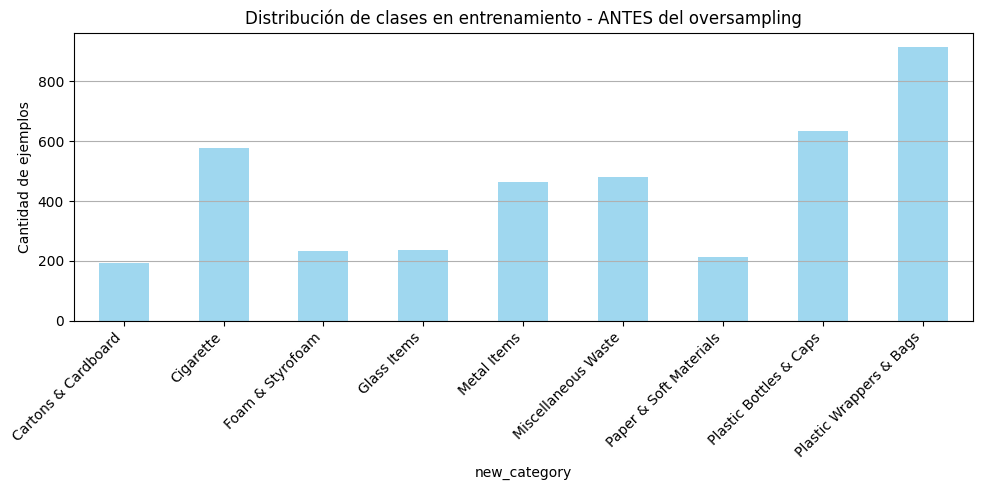

In [9]:
import matplotlib.pyplot as plt

# Recuento de clases en el train_df original (sin duplicados)
before_counts = train_df["new_category"].value_counts().sort_index()
ordered_classes = before_counts.index.tolist()  # para mantener orden

# Gráfico
plt.figure(figsize=(10, 5))
before_counts.plot(kind='bar', alpha=0.8, color='skyblue')
plt.title("Distribución de clases en entrenamiento - ANTES del oversampling")
plt.ylabel("Cantidad de ejemplos")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [10]:
# Verificar que cada imagen tenga su etiqueta correspondiente
from pathlib import Path

img_dir = Path("/content/taco_yolo_format/images/train")
lbl_dir = Path("/content/taco_yolo_format/labels/train")

img_files = set(f.stem for f in img_dir.glob("*.jpg"))
lbl_files = set(f.stem for f in lbl_dir.glob("*.txt"))

missing_labels = img_files - lbl_files
missing_images = lbl_files - img_files

print(f"Imágenes sin etiquetas: {len(missing_labels)}")
print(f"Etiquetas sin imágenes: {len(missing_images)}")

if missing_labels:
    print("Archivos sin etiqueta:", sorted(missing_labels)[:5])
if missing_images:
    print("Archivos sin imagen:", sorted(missing_images)[:5])

Imágenes sin etiquetas: 0
Etiquetas sin imágenes: 0


In [11]:
import shutil
from pathlib import Path
from collections import Counter
import random

TARGET_COUNT = 900
img_dir = Path("/content/taco_yolo_format/images/train")
lbl_dir = Path("/content/taco_yolo_format/labels/train")

# Leer etiquetas y contar clases
img_labels = {}
class_counts = Counter()

for lbl_file in lbl_dir.glob("*.txt"):
    with open(lbl_file) as f:
        labels = [int(float(line.split()[0])) for line in f.read().splitlines()]
        img_labels[lbl_file.stem] = labels
        class_counts.update(labels)

# Oversampling (controlado)
for class_id, count in class_counts.items():
    needed = TARGET_COUNT - count
    if needed <= 0:
        continue

    candidate_images = sorted(
        [stem for stem, labels in img_labels.items() if class_id in labels],
        key=lambda x: len(img_labels[x])
    )

    if not candidate_images:
        print(f"No se encontraron imágenes para la clase {class_id}.")
        continue

    for i in range(needed):
        chosen_stem = random.choice(candidate_images)
        new_stem = f"{chosen_stem}_oversampled_{class_id}_{i}"

        shutil.copy(img_dir / f"{chosen_stem}.jpg", img_dir / f"{new_stem}.jpg")
        shutil.copy(lbl_dir / f"{chosen_stem}.txt", lbl_dir / f"{new_stem}.txt")

print("Oversampling terminado correctamente.")


Oversampling terminado correctamente.


In [12]:
from pathlib import Path
from collections import Counter

# Lista de nombres de clases (ordenadas por ID)
final_classes = [
    "Cartons & Cardboard",       # id 0
    "Cigarette",                 # id 1
    "Foam & Styrofoam",          # id 2
    "Glass Items",               # id 3
    "Metal Items",               # id 4
    "Miscellaneous Waste",       # id 5
    "Paper & Soft Materials",    # id 6
    "Plastic Bottles & Caps",    # id 7
    "Plastic Wrappers & Bags"    # id 8
]

label_dir = Path("/content/taco_yolo_format/labels/train")
class_counts = Counter()

# Leer todas las etiquetas YOLO
for lbl_file in label_dir.glob("*.txt"):
    with open(lbl_file) as f:
        for line in f:
            cls_id = int(float(line.strip().split()[0]))  # soporta etiquetas tipo "8.0"
            class_counts[cls_id] += 1

# Mostrar resultados
print("📊 Distribución de clases después del oversampling:\n")
for cls_id in sorted(class_counts.keys()):
    name = final_classes[cls_id] if cls_id < len(final_classes) else "Desconocida"
    print(f"Clase {cls_id:>2} - {name:<25}: {class_counts[cls_id]} ejemplos")


📊 Distribución de clases después del oversampling:

Clase  0 - Cartons & Cardboard      : 1908 ejemplos
Clase  1 - Cigarette                : 5547 ejemplos
Clase  2 - Foam & Styrofoam         : 2034 ejemplos
Clase  3 - Glass Items              : 1696 ejemplos
Clase  4 - Metal Items              : 5732 ejemplos
Clase  5 - Miscellaneous Waste      : 4957 ejemplos
Clase  6 - Paper & Soft Materials   : 3221 ejemplos
Clase  7 - Plastic Bottles & Caps   : 5360 ejemplos
Clase  8 - Plastic Wrappers & Bags  : 5097 ejemplos


### YOLO small

In [ ]:
from ultralytics import YOLO

# Cargar modelo YOLOv8s preentrenado
model = YOLO("yolov8s.pt")

# Entrenar con dataset TACO (ya oversampled)
model.train(
    data="/content/taco_yolo_format/data.yaml",  # dataset oversampled
    epochs=10,                                   # número de épocas
    imgsz=640,                                   # tamaño de imagen
    batch=16,                                    # tamaño de batch
    lr0=0.003,                                   # learning rate ajustado
    name="taco-yolo8s-oversampled"               # nombre claro para el entrenamiento
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 298MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/taco_yolo_format/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=taco-yolo8s-oversampled, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 42.8MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 164MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1567.4±1489.8 MB/s, size: 1438.5 KB)


train: Scanning /content/taco_yolo_format/labels/train... 7694 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7694/7694 [00:13<00:00, 552.48it/s]


train: New cache created: /content/taco_yolo_format/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 105.5±20.6 MB/s, size: 1214.2 KB)


val: Scanning /content/taco_yolo_format/labels/val... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 281.75it/s]

val: New cache created: /content/taco_yolo_format/labels/val.cache


Plotting labels to runs/detect/taco-yolo8s-oversampled/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/taco-yolo8s-oversampled
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.54G     0.8289      2.061      0.958         28        640: 100%|██████████| 481/481 [07:56<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

                   all        128        336      0.229      0.198      0.136      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       4.7G     0.6973     0.7001     0.8892         44        640: 100%|██████████| 481/481 [07:48<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        128        336      0.197      0.155     0.0953     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.74G     0.6468     0.5726     0.8697         60        640: 100%|██████████| 481/481 [07:48<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        336      0.143      0.211       0.12     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.77G     0.5863     0.4698     0.8475         59        640: 100%|██████████| 481/481 [07:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        128        336      0.348      0.102     0.0808     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.81G     0.5174     0.3896     0.8288         84        640: 100%|██████████| 481/481 [07:50<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        128        336      0.166      0.155      0.106     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.85G     0.4592     0.3385     0.8127         84        640: 100%|██████████| 481/481 [07:44<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        128        336      0.263       0.16      0.123     0.0938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.88G     0.4193     0.3064     0.8054         60        640: 100%|██████████| 481/481 [07:50<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        128        336      0.223      0.163      0.101     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.92G      0.375     0.2737     0.7945         57        640: 100%|██████████| 481/481 [07:49<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        128        336      0.349      0.146      0.151      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.96G      0.341     0.2513      0.789         39        640: 100%|██████████| 481/481 [07:50<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        128        336      0.193      0.152      0.134      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.99G     0.3058     0.2305     0.7832         55        640: 100%|██████████| 481/481 [07:45<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        128        336      0.227      0.159      0.142      0.112



10 epochs completed in 1.314 hours.
Optimizer stripped from runs/detect/taco-yolo8s-oversampled/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/taco-yolo8s-oversampled/weights/best.pt, 22.5MB

Validating runs/detect/taco-yolo8s-oversampled/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


                   all        128        336      0.348      0.146      0.151      0.119
   Cartons & Cardboard         14         18       0.43      0.278      0.397      0.291
             Cigarette         19         31      0.802     0.0968      0.111     0.0923
      Foam & Styrofoam         19         21      0.201     0.0952     0.0944     0.0944
           Glass Items          5          8      0.325      0.125     0.0823     0.0764
           Metal Items         15         28      0.165      0.214      0.153      0.119
   Miscellaneous Waste         30         53      0.193     0.0189     0.0454      0.025
Paper & Soft Materials         18         27      0.216      0.037     0.0308     0.0268
Plastic Bottles & Caps         50         74      0.397      0.189      0.224      0.178
Plastic Wrappers & Bags         57         76      0.406      0.263      0.223       0.17
Speed: 0.7ms preprocess, 5.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa5852828d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [ ]:
import shutil
import os

# Ruta donde YOLO guarda los resultados por defecto
source_dir = '/content/runs/detect/taco-yolo8s-oversampled'

# Ruta en Google Drive
dest_dir = '/content/drive/MyDrive/YOLOv8_Checkpoints_2'


# Eliminar la carpeta de destino si ya existe para sobrescribirla
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copiar los resultados al Drive
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive: {dest_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado exitosamente en: /content/drive/MyDrive/YOLOv8_Checkpoints/taco_yolov8s_oversampled_best.pt


In [ ]:
from ultralytics import YOLO

# Cargar modelo guardado en Drive
model = YOLO("/content/drive/MyDrive/YOLOv8_Checkpoints/taco_yolov8s_oversampled_best.pt")

# Evaluar (recalcula mAP, precisión, recall y guarda CSV + gráficos)
results = model.val(data="/content/taco_yolo_format/data.yaml")

# Ver los resultados
print(results)


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 100.0±23.0 MB/s, size: 1563.9 KB)



val: Scanning /content/taco_yolo_format/labels/val... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 227.21it/s]

val: New cache created: /content/taco_yolo_format/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:53<00:00, 14.20s/it]


                   all        128        336      0.348      0.143      0.152      0.121
   Cartons & Cardboard         14         18      0.436      0.278      0.402      0.302
             Cigarette         19         31      0.809     0.0968      0.111     0.0858
      Foam & Styrofoam         19         21      0.204     0.0952     0.0954     0.0954
           Glass Items          5          8      0.327      0.125     0.0829     0.0769
           Metal Items         15         28      0.165      0.214      0.148      0.115
   Miscellaneous Waste         30         53      0.194     0.0189     0.0473     0.0267
Paper & Soft Materials         18         27      0.218      0.037      0.036     0.0313
Plastic Bottles & Caps         50         74      0.401      0.189      0.227      0.186
Plastic Wrappers & Bags         57         76      0.382      0.237       0.22       0.17
Speed: 7.5ms preprocess, 781.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/det

In [ ]:
from ultralytics import YOLO
import os
import shutil

# 1. Cargar modelo
model = YOLO("/content/drive/MyDrive/YOLOv8_Checkpoints/taco_yolov8s_oversampled_best.pt")

# 2. Evaluar el modelo
results = model.val(data="/content/taco_yolo_format/data.yaml")

# 3. Detectar la carpeta donde YOLO guardó los gráficos
val_root = "runs/detect"  # puede ser también runs/val dependiendo del tipo de tarea
latest_exp = sorted(os.listdir(val_root), key=lambda x: os.path.getmtime(os.path.join(val_root, x)))[-1]
val_results_path = os.path.join(val_root, latest_exp)
print(f"Carpeta de resultados: {val_results_path}")

# 4. Copiar carpeta completa de resultados a Google Drive
dest_drive_path = "/content/drive/MyDrive/YOLOv8_Checkpoints/val_results"
shutil.copytree(val_results_path, dest_drive_path, dirs_exist_ok=True)
print(f"Resultados copiados en: {dest_drive_path}")


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1876.1±458.9 MB/s, size: 1092.1 KB)


val: Scanning /content/taco_yolo_format/labels/val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:45<00:00, 13.15s/it]


                   all        128        336      0.348      0.143      0.152      0.121
   Cartons & Cardboard         14         18      0.436      0.278      0.402      0.302
             Cigarette         19         31      0.809     0.0968      0.111     0.0858
      Foam & Styrofoam         19         21      0.204     0.0952     0.0954     0.0954
           Glass Items          5          8      0.327      0.125     0.0829     0.0769
           Metal Items         15         28      0.165      0.214      0.148      0.115
   Miscellaneous Waste         30         53      0.194     0.0189     0.0473     0.0267
Paper & Soft Materials         18         27      0.218      0.037      0.036     0.0313
Plastic Bottles & Caps         50         74      0.401      0.189      0.227      0.186
Plastic Wrappers & Bags         57         76      0.382      0.237       0.22       0.17
Speed: 4.1ms preprocess, 747.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/det

In [13]:
from google.colab import drive
from ultralytics import YOLO

drive.mount('/content/drive')

# Cargar modelo desde checkpoint guardado
model = YOLO('/content/drive/MyDrive/YOLOv8_Checkpoints/taco_yolov8s_oversampled_best.pt')

# Continuar entrenando desde checkpoint
model.train(
    data="/content/taco_yolo_format/data.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    lr0=0.003,
    name="taco-yolo8s-oversampled2"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Checkpoints/taco_yolov8s_oversampled_best.pt, data=/content/taco_yolo_format/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=taco-yolo8s-oversampled2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosai

100%|██████████| 755k/755k [00:00<00:00, 26.2MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2119531  ultralytics.nn.modules.head.Detect           [9, [128, 256, 512]]          
Model summary: 129 layers, 11,139,083 parameters, 11,139,067 gradients, 28.7 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mi

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1925.6±1644.7 MB/s, size: 1483.4 KB)


train: Scanning /content/taco_yolo_format/labels/train... 7694 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7694/7694 [00:13<00:00, 561.28it/s]


train: New cache created: /content/taco_yolo_format/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 91.6±20.8 MB/s, size: 1214.2 KB)


val: Scanning /content/taco_yolo_format/labels/val... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 280.99it/s]

val: New cache created: /content/taco_yolo_format/labels/val.cache


Plotting labels to runs/detect/taco-yolo8s-oversampled2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/taco-yolo8s-oversampled2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.57G     0.4888       0.43     0.8661         80        640: 100%|██████████| 481/481 [07:57<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

                   all        128        336      0.287      0.177      0.136      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.73G     0.5123     0.4237     0.8632         99        640: 100%|██████████| 481/481 [07:54<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        128        336      0.351      0.118      0.114     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.77G     0.5346     0.4416     0.8655        102        640: 100%|██████████| 481/481 [07:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        128        336      0.129      0.133     0.0836      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       4.8G     0.5316     0.4361     0.8636         97        640: 100%|██████████| 481/481 [08:03<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        128        336      0.294      0.128      0.106     0.0746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.84G     0.5011      0.396     0.8546        101        640: 100%|██████████| 481/481 [07:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        128        336      0.302      0.132      0.101     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.87G      0.484     0.3744     0.8491         69        640: 100%|██████████| 481/481 [07:43<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        128        336      0.186      0.153       0.11     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.91G     0.4549     0.3467     0.8426        108        640: 100%|██████████| 481/481 [07:43<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        128        336      0.252      0.167      0.127     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.95G      0.439     0.3334     0.8385        116        640: 100%|██████████| 481/481 [07:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        128        336      0.266      0.109      0.106     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.98G     0.4227     0.3206      0.835        127        640: 100%|██████████| 481/481 [07:46<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        128        336       0.23      0.116        0.1     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.02G     0.4087     0.3105     0.8305         90        640: 100%|██████████| 481/481 [07:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        128        336      0.118      0.118     0.0926     0.0666


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.06G     0.3541     0.2596     0.7914         70        640: 100%|██████████| 481/481 [07:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        128        336      0.258      0.162       0.15      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.09G     0.3335     0.2461     0.7864         50        640: 100%|██████████| 481/481 [07:41<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        128        336       0.17      0.114      0.103     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.13G     0.3136     0.2326     0.7835         43        640: 100%|██████████| 481/481 [07:37<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        128        336     0.0989      0.254      0.117     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.16G     0.3008     0.2249     0.7818         53        640: 100%|██████████| 481/481 [07:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        128        336      0.104      0.225      0.123     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       5.2G     0.2857     0.2151     0.7794         64        640: 100%|██████████| 481/481 [07:37<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        128        336      0.103      0.197      0.115     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.24G     0.2684     0.2051     0.7764         50        640: 100%|██████████| 481/481 [07:30<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        128        336      0.108      0.245       0.12     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.27G     0.2597     0.1987     0.7773         68        640: 100%|██████████| 481/481 [07:38<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        128        336      0.105      0.214      0.116     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.31G     0.2448     0.1896      0.775         40        640: 100%|██████████| 481/481 [07:35<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        128        336       0.12      0.229      0.128     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.35G     0.2333     0.1825     0.7718         59        640: 100%|██████████| 481/481 [07:35<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        128        336      0.124      0.229      0.129        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.38G      0.224     0.1767     0.7733         44        640: 100%|██████████| 481/481 [07:37<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        128        336      0.124      0.218       0.13     0.0994



20 epochs completed in 2.595 hours.
Optimizer stripped from runs/detect/taco-yolo8s-oversampled2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/taco-yolo8s-oversampled2/weights/best.pt, 22.5MB

Validating runs/detect/taco-yolo8s-oversampled2/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


                   all        128        336      0.257      0.162      0.149      0.114
   Cartons & Cardboard         14         18      0.508      0.222      0.373      0.248
             Cigarette         19         31      0.276     0.0645     0.0691      0.047
      Foam & Styrofoam         19         21      0.124     0.0686     0.0463     0.0257
           Glass Items          5          8      0.588       0.25       0.24       0.23
           Metal Items         15         28      0.177      0.286      0.127     0.0934
   Miscellaneous Waste         30         53          0          0     0.0228     0.0148
Paper & Soft Materials         18         27      0.131      0.111     0.0856      0.072
Plastic Bottles & Caps         50         74      0.284      0.203      0.179      0.142
Plastic Wrappers & Bags         57         76      0.221       0.25      0.203      0.156
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9dc15ea450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [14]:
import shutil
import os

# Ruta donde YOLO guarda los resultados por defecto
source_dir = '/content/runs/detect/taco-yolo8s-oversampled2'

# Ruta en Google Drive
dest_dir = '/content/drive/MyDrive/YOLOv8_Checkpoints_2'


# Eliminar la carpeta de destino si ya existe para sobrescribirla
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copiar los resultados al Drive
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive: {dest_dir}")

Resultados guardados en Google Drive: /content/drive/MyDrive/YOLOv8_Checkpoints_2


In [15]:
from google.colab import drive
from ultralytics import YOLO

drive.mount('/content/drive')

# Cargar modelo desde checkpoint guardado
model = YOLO('/content/drive/MyDrive/YOLOv8_Checkpoints_2/weights/best.pt')

# Continuar entrenando desde checkpoint
model.train(
    data="/content/taco_yolo_format/data.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    lr0=0.001,
    name="taco-yolo8s-oversampled3"
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Checkpoints_2/weights/best.pt, data=/content/taco_yolo_format/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=taco-yolo8s-oversampled3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agn

train: Scanning /content/taco_yolo_format/labels/train.cache... 7694 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7694/7694 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1143.1±1077.2 MB/s, size: 1214.2 KB)


val: Scanning /content/taco_yolo_format/labels/val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/taco-yolo8s-oversampled3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/taco-yolo8s-oversampled3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.05G     0.3111      0.233     0.7831         38        640: 100%|██████████| 481/481 [08:16<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        128        336      0.203      0.145      0.126      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.16G     0.3514      0.266     0.7915         53        640: 100%|██████████| 481/481 [08:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        128        336      0.505      0.148      0.127     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.16G     0.3746     0.2842     0.7949         78        640: 100%|██████████| 481/481 [07:53<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        128        336      0.202      0.118      0.104     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.16G     0.3659     0.2769     0.7914         68        640: 100%|██████████| 481/481 [07:57<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        128        336      0.163      0.118      0.105     0.0776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.16G      0.347     0.2628     0.7887         77        640: 100%|██████████| 481/481 [07:56<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        128        336      0.153      0.127     0.0959     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.16G     0.3223     0.2403     0.7844         72        640: 100%|██████████| 481/481 [07:56<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        128        336      0.213      0.143      0.131      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.16G     0.2985     0.2247     0.7824         81        640: 100%|██████████| 481/481 [08:02<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        336      0.253      0.122      0.139      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.16G     0.2754     0.2087     0.7764         63        640: 100%|██████████| 481/481 [08:01<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        128        336       0.13      0.251      0.131      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.16G     0.2589     0.1989      0.775         48        640: 100%|██████████| 481/481 [07:59<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        128        336      0.264      0.133      0.121     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.16G      0.236     0.1843     0.7721         38        640: 100%|██████████| 481/481 [07:59<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        128        336      0.125      0.217      0.138      0.111



10 epochs completed in 1.349 hours.
Optimizer stripped from runs/detect/taco-yolo8s-oversampled3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/taco-yolo8s-oversampled3/weights/best.pt, 22.5MB

Validating runs/detect/taco-yolo8s-oversampled3/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


                   all        128        336      0.125      0.217      0.138       0.11
   Cartons & Cardboard         14         18        0.2      0.333      0.179       0.12
             Cigarette         19         31        0.1     0.0968     0.0998     0.0424
      Foam & Styrofoam         19         21      0.122      0.238     0.0961     0.0942
           Glass Items          5          8      0.125       0.25      0.253      0.242
           Metal Items         15         28      0.106      0.357      0.165      0.128
   Miscellaneous Waste         30         53      0.108     0.0755     0.0621     0.0458
Paper & Soft Materials         18         27          0          0          0          0
Plastic Bottles & Caps         50         74      0.207      0.257      0.183      0.159
Plastic Wrappers & Bags         57         76      0.156      0.342      0.203      0.159
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9f3b946490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [16]:
import shutil
import os

# Ruta donde YOLO guarda los resultados por defecto
source_dir = '/content/runs/detect/taco-yolo8s-oversampled3'

# Ruta en Google Drive
dest_dir = '/content/drive/MyDrive/YOLOv8_Checkpoints_3'


# Eliminar la carpeta de destino si ya existe para sobrescribirla
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copiar los resultados al Drive
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive: {dest_dir}")

Resultados guardados en Google Drive: /content/drive/MyDrive/YOLOv8_Checkpoints_3


In [ ]:
%%script echo skipping

import shutil
import os

source_dir = "/content/runs/detect/taco-yolo8s-lr003"
dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo8s-lr003"

# Borrar carpeta destino si ya existe
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)  # Elimina toda la carpeta

# Copiar nuevamente
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive (sobrescribiendo si existía): {dest_dir}")


In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo entrenado
model_yolos_lr003 = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-lr003/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolos_lr003.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes


In [ ]:
%%script echo skipping

metrics_yolos_lr003 = model_yolos_lr003.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolos_lr003.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolos_lr003.box.map:.4f}")
print(f"Precisión: {metrics_yolos_lr003.box.mp:.4f}")
print(f"Recall:    {metrics_yolos_lr003.box.mr:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-lr003"


file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


In [ ]:
# Lista con los nombres de los archivos de imagen que querés mostrar
image_files = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "F1_curve.png",
    "labels_correlogram.jpg",
    "labels.jpg",
    "P_curve.png",
    "PR_curve.png",
    "R_curve.png",
]

# Configuración del tamaño de la grilla
cols = 2
rows = (len(image_files) + cols - 1) // cols  # redondeo hacia arriba

# Crear la grilla
plt.figure(figsize=(15, 5 * rows))

for i, img_file in enumerate(image_files):
    file_path = os.path.join(path, img_file)
    if os.path.exists(file_path):
        img = mpimg.imread(file_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file, fontsize=10)
    else:
        print(f"Imagen no encontrada: {file_path}")

plt.tight_layout()
plt.show()


### Conclusión general del entrenamiento (Modelo 4)

| Métrica           | Estado     | Comentario breve                                                        |
|-------------------|------------|--------------------------------------------------------------------------|
| **Losses**        | Muy bien | Pérdidas bajan de forma clara; el `val/cls_loss` inicia alto pero se estabiliza |
| **Precisión**     | Estable  | Se mantiene sobre 0.25 con menos variabilidad que en modelos anteriores |
| **Recall**        | En ascenso | Mejora progresiva y llega a ~0.22 al final del entrenamiento             |
| **mAP@0.5**        | Mejorado | Llega a ~0.14 y se mantiene alto en las últimas épocas                   |
| **mAP@0.5:0.95**   | Mejorado | Se estabiliza en torno a 0.10, con buena tendencia final                 |


### Comparativa final de los cuatro modelos entrenados

| Métrica           | Modelo 1       | Modelo 2       | Modelo 3         | Modelo 4         |
|-------------------|----------------|----------------|------------------|------------------|
| **Losses**        | Muy bien     | Muy bien     | Muy bien       | Muy bien       |
| **Precisión**     |  Inestable    |  Inestable    |  Variable       | Estable        |
| **Recall**        |  Muy bajo     |  Mejorado     |  Aceptable      | En ascenso     |
| **mAP@0.5**        |  Bajo         |  Aceptable    |  Bueno          |  Mejorado |
| **mAP@0.5:0.95**   |  Muy bajo     |  Moderado     |  Mejorado       |  Mejorado      |


###  Conclusión general

A lo largo del entrenamiento de los distintos modelos, se observó una mejora progresiva en el rendimiento de detección, especialmente en términos de `recall`, `mAP@0.5` y `mAP@0.5:0.95`.

- El **Modelo 1** sirvió como punto de partida, mostrando pérdidas decrecientes pero con un `recall` y `mAP` muy bajos, lo que indicaba un modelo que aprendía poco del conjunto.
- El **Modelo 2** logró una mejora significativa en `mAP@0.5`, aunque aún con variaciones importantes en la precisión.
- El **Modelo 3** consolidó el aprendizaje, alcanzando un rendimiento más robusto y equilibrado, con mejoras claras en todas las métricas.
- El **Modelo 4** (renombrado, originalmente Modelo 5) fue el más consistente y completo de todos, con pérdidas estables, mayor `recall`, precisión estable, y un `mAP@0.5` sostenido cerca de 0.14. Además, mostró una clara tendencia positiva en `mAP@0.5:0.95`, siendo ideal para una implementación más fina o despliegue en producción.

En resumen, el Modelo 4 representa el mejor compromiso entre precisión, recall y generalización, y se sugiere como candidato principal para tareas de inferencia o extensión con técnicas adicionales como fine-tuning, ajuste de umbrales o cuantización para despliegue.


### Intento de fine tuning

In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo YOLOv8s preentrenado
model = YOLO("yolov8s.pt")

model.train(
    data="/content/taco_yolo_format/data.yaml",
    epochs=20,             # Menos épocas
    imgsz=768,             # Más resolución (opcional pero recomendable)
    batch=16,
    lr0=0.001,            # learning rate más bajo
    name="taco-yolo8s-finetune"
)


In [ ]:
%%script echo skipping

import shutil
import os

source_dir = "/content/runs/detect/taco-yolo8s-finetune"
dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo8s-finetune"

# Borrar carpeta destino si ya existe
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)  # Elimina toda la carpeta

# Copiar nuevamente
shutil.copytree(source_dir, dest_dir)

dest_dir2 = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-finetune"
print(f"Resultados guardados en Google Drive (sobrescribiendo si existía): {dest_dir}")


In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo entrenado
model_yolo8s_finetune = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-finetune/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolo8s_finetune.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes


In [ ]:
%%script echo skipping

metrics_yolo8s_finetune = model_yolos_lr003.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolo8s_finetune.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolo8s_finetune.box.map:.4f}")
print(f"Precisión: {metrics_yolo8s_finetune.box.mp:.4f}")
print(f"Recall:    {metrics_yolo8s_finetune.box.mr:.4f}")

In [ ]:
%%script echo skipping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes (ajustala según tu caso)
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-finetune"


file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


# RetinaNET

In [ ]:
import os
import json
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


### Cargar anotaciones y definir clases

In [ ]:
# Instalar kagglehub si no lo tenés
!pip install -q kagglehub

import kagglehub
import os

# Descargar el dataset
dataset_path = kagglehub.dataset_download("kneroma/tacotrashdataset")
print(f"📁 Dataset descargado en: {dataset_path}")

# Buscar archivo annotations.json dentro de la carpeta
DATASET_PATH = os.path.join(dataset_path, "data")
ANNOTATION_FILE = os.path.join(DATASET_PATH, "annotations.json")

# Verificar que existe
if os.path.exists(ANNOTATION_FILE):
    print("✅ Archivo 'annotations.json' encontrado.")
else:
    raise FileNotFoundError(f"❌ No se encontró 'annotations.json' en {DATASET_PATH}. Revisa la ruta o descarga.")


In [ ]:
# Cargar el JSON
with open(ANNOTATION_FILE, "r") as f:
    annotations = json.load(f)

print("Anotaciones cargadas correctamente.")


#
custom_mapping = {
    "Cigarette": ["Cigarette"],
    "Glass Items": ["Broken glass", "Glass bottle", "Glass cup", "Glass jar"],
    "Metal Items": ["Drink can", "Pop tab", "Metal bottle cap", "Aluminium foil", "Scrap metal",
                    "Metal lid", "Aerosol", "Food Can", "Aluminium blister pack"],
    "Plastic Bottles & Caps": ["Plastic bottle cap", "Plastic bottle", "Other plastic bottle",
                               "Plastic utensils", "Tupperware", "Polypropylene bag", "Plastic straw",
                               "Plastic lid", "Plastic glooves", "Other plastic cup", "Clear plastic bottle"],
    "Plastic Wrappers & Bags": ["Plastic film", "Other plastic wrapper", "Single-use carrier bag",
                                "Other plastic container", "Garbage bag", "Plastic bag", "Other plastic bag",
                                "Crisp packet", "Other plastic"],
    "Cartons & Cardboard": ["Other carton", "Drink carton", "Meal carton", "Pizza box", "Corrugated carton"],
    "Paper & Soft Materials": ["Normal paper", "Paper cup", "Paper bag", "Magazine paper",
                               "Wrapping paper", "Egg carton", "Toilet tube", "Paper straw", "Tissues"],
    "Foam & Styrofoam": ["Styrofoam piece", "Disposable plastic cup", "Disposable food container",
                          "Foam food container", "Foam cup"],
    "Miscellaneous Waste": ["Unlabeled litter", "Rope & strings", "Food waste", "Shoe",
                            "Squeezable tube", "Battery", "Carded blister pack", "Spread tub", "Six pack rings"]
}

# Crear mapeos
category_map = {cat['id']: cat['name'] for cat in annotations['categories']}
class_to_material = {name: group for group, names in custom_mapping.items() for name in names}
final_classes = sorted(custom_mapping.keys())
class_to_id = {cls: i for i, cls in enumerate(final_classes)}

# Construir dataframe de anotaciones
annotation_df = pd.DataFrame(annotations['annotations'])
annotation_df['category_name'] = annotation_df['category_id'].map(category_map)
annotation_df['new_category'] = annotation_df['category_name'].map(class_to_material)
image_map = {img['id']: img for img in annotations['images']}


In [ ]:
print(class_to_id)

### Verificación de integridad del dataset

In [ ]:
from pathlib import Path

# Total de imágenes definidas en el JSON
total_images = len(annotations['images'])
print(f"Total de imágenes en el dataset: {total_images}")

# 1. Verificar existencia de imágenes
missing_images = [
    img['file_name']
    for img in annotations['images']
    if not Path(os.path.join(DATASET_PATH, img['file_name'])).exists()
]

print(f"Imágenes faltantes: {len(missing_images)}")
if missing_images:
    print("Ejemplos:", missing_images[:5])

# 2. Verificar bboxes válidos
def is_valid_bbox(bbox):
    return (
        isinstance(bbox, list) and len(bbox) == 4 and
        all(isinstance(v, (int, float)) for v in bbox) and
        bbox[2] > 0 and bbox[3] > 0
    )

invalid_bboxes = annotation_df[~annotation_df['bbox'].apply(is_valid_bbox)]
print(f"Anotaciones con bbox inválido: {len(invalid_bboxes)}")

# 3. Verificar clases no mapeadas
unmapped_classes = annotation_df[annotation_df['new_category'].isna()]['category_name'].unique()
print(f"Clases sin asignar a agrupaciones: {unmapped_classes}")

# 4. Verificar imágenes sin anotaciones
images_with_annot = set(annotation_df['image_id'].unique())
images_defined = set(img['id'] for img in annotations['images'])
images_without_annot = images_defined - images_with_annot

print(f"Imágenes sin anotaciones: {len(images_without_annot)}")


### Separar train y val

In [ ]:
annotation_df = annotation_df[annotation_df['new_category'].notna()]

image_ids = annotation_df["image_id"].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

train_df = annotation_df[annotation_df["image_id"].isin(train_ids)]
val_df = annotation_df[annotation_df["image_id"].isin(val_ids)]


### Dataset personalizado para RetinaNet

In [ ]:
class TacoRetinaDataset(Dataset):
    def __init__(self, annotation_df, image_map, class_to_id, transform=None):
        self.annotation_df = annotation_df
        self.image_ids = annotation_df['image_id'].unique()
        self.image_map = image_map
        self.class_to_id = class_to_id
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_map[img_id]
        img_path = os.path.join(DATASET_PATH, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        records = self.annotation_df[self.annotation_df["image_id"] == img_id]
        boxes, labels = [], []

        for _, row in records.iterrows():
            x, y, w, h = row["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.class_to_id[row["new_category"]])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target


### Crear dataloaders

In [ ]:
transform = transforms.ToTensor()

train_dataset = TacoRetinaDataset(train_df, image_map, class_to_id, transform)
val_dataset = TacoRetinaDataset(val_df, image_map, class_to_id, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


### Primer modelo

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights

# Cargar modelo con pesos preentrenados
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = retinanet_resnet50_fpn(weights=weights)

# Definir cantidad de clases (agregando background)
num_classes = len(final_classes) + 1
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors

# Reemplazar la cabeza del modelo con la cantidad correcta de clases
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)


### Entrenamiento

In [ ]:
%%script echo skipping

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/10 - Loss: 381.2355

Epoch 2/10 - Loss: 303.1587

Epoch 3/10 - Loss: 272.3483

Epoch 4/10 - Loss: 245.6615

Epoch 5/10 - Loss: 232.0336

Epoch 6/10 - Loss: 215.1497

Epoch 7/10 - Loss: 206.8556

Epoch 8/10 - Loss: 203.9247

Epoch 9/10 - Loss: 189.6175

Epoch 10/10 - Loss: 180.5120

### Evaluación con torchmetrics

In [ ]:
%%script echo skipping

# Ruta donde guardar en tu Google Drive
model_save_path = "/content/drive/MyDrive/retinanet_taco.pth"

# Guardar el estado del modelo
torch.save(model.state_dict(), model_save_path)
print(f"✅ Modelo guardado en: {model_save_path}")


In [ ]:
%%script echo skipping

import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Ruta donde guardaste el modelo en Google Drive
model_save_path = "/content/drive/MyDrive/VpCII/VC2/retinanet/retinanet_taco.pth"

# Debe coincidir con el entrenamiento original
num_classes = len(final_classes) + 1  # +1 por background

# Crear modelo base sin pesos (ya los cargaremos)
model = retinanet_resnet50_fpn(weights=None)

# Reemplazar cabeza de clasificación
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)

# Cargar pesos entrenados
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Inicializar métricas
metric = MeanAveragePrecision(class_metrics=True)

# Evaluación
with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        preds = model(images)
        metric.update(preds, targets)

# Resultados globales
results = metric.compute()

print("\nEvaluación general del modelo:")
print(f"  mAP      : {results['map']:.4f}")
print(f"  mAP@50   : {results['map_50']:.4f}")
print(f"  mAP@75   : {results['map_75']:.4f}")

# Resultados por clase
print("\nResultados por clase:")
for i, class_name in enumerate(final_classes):
    ap = results['map_per_class'][i].item() if results['map_per_class'][i] is not None else 0.0

    print(f"{class_name:<30} | AP = {ap:.4f}")


Evaluación general del modelo:

  mAP      : 0.0480

  mAP@50   : 0.0783

  mAP@75   : 0.0479

Resultados por clase:

Cartons & Cardboard            | AP = 0.0561

Cigarette                      | AP = 0.0412

Foam & Styrofoam               | AP = 0.0449

Glass Items                    | AP = 0.0126

Metal Items                    | AP = 0.0561

Miscellaneous Waste            | AP = 0.0100

Paper & Soft Materials         | AP = 0.0629

Plastic Bottles & Caps         | AP = 0.0774

Plastic Wrappers & Bags        | AP = 0.0712

In [ ]:
%%script echo skipping

import matplotlib.pyplot as plt

class_names = final_classes
aps = [ap.item() if ap is not None else 0.0 for ap in results['map_per_class']]

plt.figure(figsize=(12, 5))
plt.bar(class_names, aps)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Precision (AP)")
plt.title("AP por clase - RetinaNet")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Pérdidas por época
losses = [381.2355, 303.1587, 272.3483, 245.6615, 232.0336, 215.1497, 206.8556, 203.9247, 189.6175, 180.5120]
epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o')
plt.title("Curva de pérdida durante el entrenamiento - RetinaNet")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


### Segundo modelo RetinaNET


 Se aplicaron mejoras concretas para optimizar su rendimiento sobre el dataset TACO. Se realizó fine-tuning del backbone ResNet50, permitiendo que el modelo ajuste también las capas convolucionales y no solo la cabeza de clasificación. Además, se incrementó la cantidad de épocas de entrenamiento de 10 a 25, y se incorporó un scheduler de learning rate (ReduceLROnPlateau) que reduce automáticamente la tasa de aprendizaje cuando la pérdida se estanca. Estas modificaciones apuntan a una mejor convergencia del modelo, mayor capacidad de adaptación al dominio específico y mejores métricas de detección, como mAP, precisión y recall.

In [ ]:
from torchvision import transforms

transform_tensor = transforms.ToTensor()

train_dataset_v2 = TacoRetinaDataset(train_df, image_map, class_to_id, transform=transform_tensor)
val_dataset_v2 = TacoRetinaDataset(val_df, image_map, class_to_id, transform=transform_tensor)

train_loader_v2 = DataLoader(train_dataset_v2, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader_v2 = DataLoader(val_dataset_v2, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
%%script echo skipping

from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

model_v2 = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)

# Descongelar el backbone (fine-tuning)
for param in model_v2.backbone.parameters():
    param.requires_grad = True

# Reemplazar cabeza de clasificación
in_features_v2 = model_v2.head.classification_head.conv[0][0].in_channels
num_anchors_v2 = model_v2.head.classification_head.num_anchors
num_classes_v2 = len(final_classes) + 1

model_v2.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features_v2,
    num_anchors=num_anchors_v2,
    num_classes=num_classes_v2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2.to(device)


In [ ]:
%%script echo skipping

import torch.optim as optim
from tqdm import tqdm

optimizer_v2 = optim.Adam(model_v2.parameters(), lr=1e-4)
scheduler_v2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v2, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs_v2 = 25
train_loss_history_v2 = []

for epoch in range(num_epochs_v2):
    model_v2.train()
    epoch_loss_v2 = 0.0
    print(f"\nEntrenando model_v2 - Epoch {epoch+1}/{num_epochs_v2}")
    pbar = tqdm(train_loader_v2, desc="Entrenando v2", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict_v2 = model_v2(images, targets)
        losses_v2 = sum(loss for loss in loss_dict_v2.values())

        optimizer_v2.zero_grad()
        losses_v2.backward()
        optimizer_v2.step()

        epoch_loss_v2 += losses_v2.item()
        pbar.set_postfix({"Batch Loss": f"{losses_v2.item():.4f}", "Epoch Loss": f"{epoch_loss_v2:.2f}"})

    scheduler_v2.step(epoch_loss_v2)
    train_loss_history_v2.append(epoch_loss_v2)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss_v2:.4f}")


Entrenando model_v2 - Epoch 1/25
Epoch 1 - Loss: 401.6814

Entrenando model_v2 - Epoch 2/25
Epoch 2 - Loss: 344.8603

Entrenando model_v2 - Epoch 3/25
Epoch 3 - Loss: 284.3562

Entrenando model_v2 - Epoch 4/25
Epoch 4 - Loss: 252.8948

Entrenando model_v2 - Epoch 5/25
Epoch 5 - Loss: 234.6337

Entrenando model_v2 - Epoch 6/25
Epoch 6 - Loss: 225.5761

Entrenando model_v2 - Epoch 7/25
Epoch 7 - Loss: 217.0480

In [ ]:
%%script echo skipping

model_save_path_v2 = "/content/drive/MyDrive/retinanet_taco_v2_finetuned.pth"
torch.save(model_v2.state_dict(), model_save_path_v2)
print(f"✅ Modelo v2 guardado en: {model_save_path_v2}")


In [ ]:
import matplotlib.pyplot as plt

# Datos del primer modelo (10 épocas)
losses_v1 = [381.2355, 303.1587, 272.3483, 245.6615, 232.0336, 215.1497, 206.8556, 203.9247, 189.6175, 180.5120]
epochs_v1 = list(range(1, len(losses_v1) + 1))

# Datos del segundo modelo (7 épocas)
losses_v2 = [401.6814, 344.8603, 284.3562, 252.8948, 234.6337, 225.5761, 217.0480]
epochs_v2 = list(range(1, len(losses_v2) + 1))

# Gráfico 1: Solo segundo modelo
plt.figure(figsize=(8, 5))
plt.plot(epochs_v2, losses_v2, marker='o', label="RetinaNet v2")
plt.title("Curva de pérdida - RetinaNet v2")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Comparación de ambos modelos
plt.figure(figsize=(8, 5))
plt.plot(epochs_v1, losses_v1, marker='o', label="RetinaNet v1")
plt.plot(epochs_v2, losses_v2, marker='o', label="RetinaNet v2")
plt.title("Comparación de pérdida entre modelos")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Teniendo en cuenta las curvas de pérdida obtenidas durante el entrenamiento, se observa que el modelo v1 presenta una mejor convergencia en comparación con el modelo v2. A pesar de haber sido entrenado durante menos épocas, el modelo v1 alcanza una pérdida considerablemente menor. Además, el modelo v2 requiere mayor tiempo de entrenamiento por época, lo cual no se justifica dado su rendimiento inferior en esta etapa.
Por lo tanto, se decidió continuar el entrenamiento del modelo v1 extendiendo la cantidad de épocas, con el objetivo de seguir mejorando su desempeño sin incurrir en costos computacionales innecesarios.

### Se entrena nuevamente el modelo 1
Este modelo se va guardando por epochs y despues se lo puede volver a entrenar desde la epoch que quedo


In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights

# Cargar modelo con pesos preentrenados
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = retinanet_resnet50_fpn(weights=weights)

# Definir cantidad de clases (agregando background)
num_classes = len(final_classes) + 1
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors

# Reemplazar la cabeza del modelo con la cantidad correcta de clases
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)


In [ ]:
import torch.optim as optim

checkpoint_dir = "/content/drive/MyDrive/checkpoints_retinanet"
os.makedirs(checkpoint_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")




    # Dentro del bucle de entrenamiento, reemplazá esto:
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, os.path.join(checkpoint_dir, f"retinanet_checkpoint_epoch_{epoch+1}.pth"))



In [ ]:
# Ruta donde guardar en tu Google Drive
full_model_path = "/content/drive/MyDrive/retinanet_taco.pth"

# Guardar el estado del modelo
torch.save(model.state_dict(), full_model_path)
print(f"✅ Modelo guardado en: {full_model_path}")

In [ ]:
import torch
import torch.optim as optim

# Cargar el checkpoint guardado
checkpoint = torch.load("retinanet_checkpoint_epoch_10.pth")

# Cargar modelo y optimizador
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Continuar desde la última época
start_epoch = checkpoint['epoch']
additional_epochs = 10  # Cuántas épocas más querés entrenar

for epoch in range(start_epoch, start_epoch + additional_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")

    # Guardar nuevo checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, f"retinanet_checkpoint_epoch_{epoch+1}.pth")


In [ ]:
# Ruta donde guardar en tu Google Drive
full_model_path = "/content/drive/MyDrive/retinanet_taco2.pth"

# Guardar el estado del modelo
torch.save(model.state_dict(), full_model_path)
print(f"✅ Modelo guardado en: {full_model_path}")